(45505, 7)


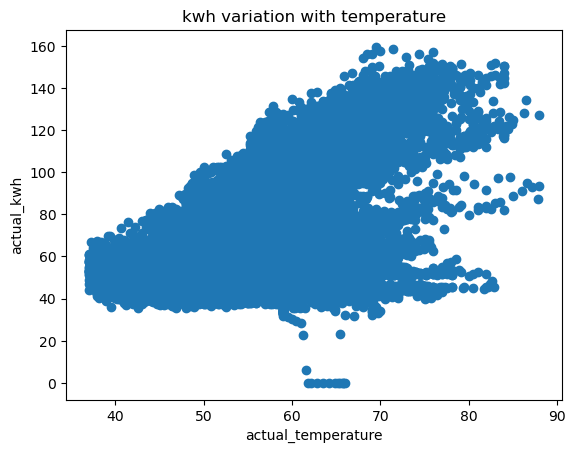

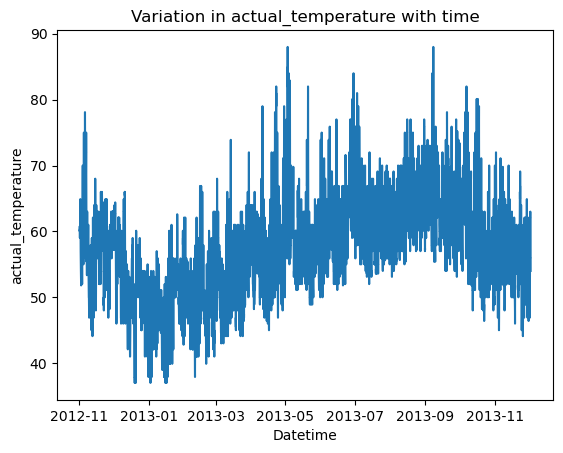

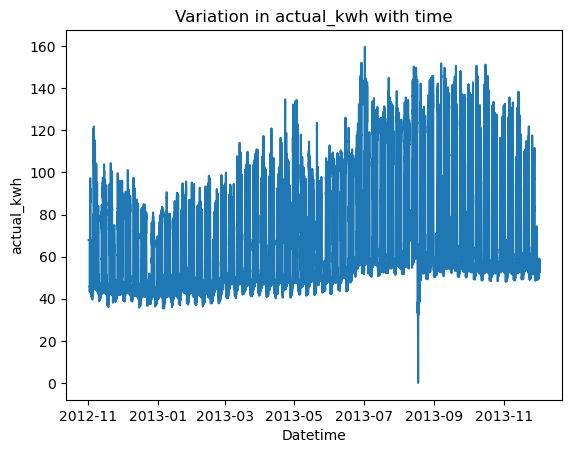

Model training completed 
In sample MSE: 477.65825526233033
Out of sample MSE: 186.19945672770268
Prediction for one temperature value - 73.75


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

class Forecaster:
    def __init__(self):
        self.model = LinearRegression()
        self.features = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def read_csv(self, file_path):
        data = pd.read_csv(file_path, parse_dates=['Unnamed: 0'])
        data.set_index('Unnamed: 0', inplace=True)
        data.index.name = 'timestamp'
        return data


    def prepare_data(self, data):
        data['timestamp'] = pd.to_datetime(data.index, utc=True) # can be converted back to original datetime later
        print(data.shape)
        data = data[pd.to_datetime(data['date']) <= '2013-12-1'] # 12/1/13
        data.set_index('timestamp', inplace=True)
        data['actual_temperature'].interpolate(method='linear', inplace=True)
        mean_kwh = data['actual_kwh'].mean()
        data['actual_kwh'] = data['actual_kwh'].fillna(mean_kwh)
#         self.features = data[['actual_temperature', 'dow', 'month']]
        self.features = data[['actual_temperature']]
        self.target = data['actual_kwh']
        
        # including some charts
        plt.scatter(self.features, self.target)
        plt.xlabel('actual_temperature')
        plt.ylabel('actual_kwh')
        plt.title("kwh variation with temperature")
        plt.show()
        
        
        plt.plot(data.index, data['actual_temperature'])
        plt.xlabel('Datetime')
        plt.ylabel('actual_temperature')
        plt.title("Variation in actual_temperature with time")
        plt.show()
        
        plt.plot(data.index, data['actual_kwh'])
        plt.xlabel('Datetime')
        plt.ylabel('actual_kwh')
        plt.title("Variation in actual_kwh with time")
        plt.show()

    def split_data(self):
        self.X_train = self.features[:-96]
        self.X_test = self.features[-96:]
        self.y_train = self.target[:-96]
        self.y_test = self.target[-96:]

    def train(self, data):
        """ Trains the model """
        self.prepare_data(data)
        self.split_data()
        
        # Train the model using training data
        self.model.fit(self.X_train, self.y_train)
        print("Model training completed ")
        
    def forecast(self, new_data):
        return self.model.predict(new_data)

class ForecastEvaluation:
    def __init__(self, forecaster):
        self.forecaster = forecaster

    def evaluate_prediction(self):
        """ Evaluates the forecast model """
#         print(self.forecaster.X_train.head())
        in_sample_predictions = self.forecaster.model.predict(self.forecaster.X_train)
        in_sample_MSE = mean_squared_error(self.forecaster.y_train, in_sample_predictions)

        out_sample_predictions = self.forecaster.model.predict(self.forecaster.X_test)
        out_sample_MSE = mean_squared_error(self.forecaster.y_test, out_sample_predictions)

        print(f"In sample MSE: {in_sample_MSE}")
        print(f"Out of sample MSE: {out_sample_MSE}")

# Example usage:
forecaster = Forecaster()
data = forecaster.read_csv('/Users/umeshnagar/Downloads/load_temperature_data.csv')


if data is not None:
    forecaster.train(data)  # Train the model
    evaluator = ForecastEvaluation(forecaster)
    evaluator.evaluate_prediction()  # Use already split data for evaluation
    
    # one data point (temperature) prediction 
    temperature_value = 60.1
    print(f"Prediction for one temperature value - {round(forecaster.forecast([[temperature_value]])[0],2)}")


## Summary of Analysis

The task is to build and evaluate a simple machine leraning model for energy forecasting, specifically predicting energy consumption (actual_kwh) based on temperature data (actual_temperature). The dataset contains energy consumption at 15-minute intervals and temperature data from November 2012 to December 2013.

### Methodology:
1. Data Preparation Step:
    * Input is read and first column has been converted into datetime timestamp in UTC formate. We need to give proper formate where it can  process datetime64 conversions and timezone information correctly handled. 
    * Missing temperature values are filled using linear interpolation. Missing values in the target column (actual_kwh) are filled with the mean energy consumption value. This is because missing values can be near to non missing values. 
    * We used only actual_temperature as the feature for the linear regression model, though other features like dow (day of the week) and month or other time features can be added for more complex forecasting. Its like y = mx + c (a very basic equation)
2. Model Training Step:
    * Train/Test Split: The data is split, with the last 96 rows (24 hours of 15-minute intervals) reserved for testing and the rest used for training.
    * Model: A linear regression model is trained using the training set (temperature as the predictor and energy consumption as the target).
3. Evaluation Step:
    * In Sample Validation: The model is evaluated on the training data to compute the mean squared error (MSE) for in sample performance.
    * Out-of-Sample Validation: The model is also evaluated on the test data to compute the out-of-sample MSE.
4. Visualization Step:
    * Few charts are plotted 
        * A scatter plot showing the relationship between actual_temperature and actual_kwh.
        * A line plot for actual_temperature variation over time.
        * A line plot for actual_kwh (energy consumption) over time.

## Key Findings:
* Correlation between Temperature and Energy Consumption: From the scatter plot, there is an observable linear relationship between temperature and energy consumption.

